<a href="https://colab.research.google.com/github/Leehong-DENG/CBIG/blob/master/%E2%80%9CW3D2_Tutorial3%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 3: The Kalman Filter
**Week 3, Day 2: Hidden Dynamics**

**By Neuromatch Academy**


__Content creators:__ Itzel Olivos Castillo and Xaq Pitkow


**Useful reference:**
- Roweis, Ghahramani (1998): A unifying review of linear Gaussian Models
- Bishop (2006): Pattern Recognition and Machine Learning

---
# Tutorial Objectives

*Estimated timing of tutorial: 1 hour, 15 minutes*

In previous tutorials we used Hidden Markov Models (HMM) to infer *discrete* latent states from a sequence of measurements. In this tutorial, we will learn how to infer a *continuous* latent variable using the Kalman filter, which is one version of an HMM.

In this tutorial, you will:
* Review linear dynamical systems
* Learn about the Kalman filter in one dimension
* Manipulate parameters of a process to see how the Kalman filter behaves
* Think about some core properties of the Kalman filter.

You can imagine this inference process happening as Mission Control tries to locate and track Astrocat. But you can also imagine that the brain is using an analogous Hidden Markov Model to track objects in the world, or to estimate the consequences of its own actions. And you could use this technique to estimate brain activity from noisy measurements, for understanding or for building a brain-machine interface.

---
# Setup

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
from collections import namedtuple
from scipy.stats import norm

In [2]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions

def visualize_Astrocat(s, T):
  plt.plot(s, color='limegreen', lw=2)
  plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  plt.xlabel('Time t')
  plt.ylabel('s(t)')


def plot_measurement(s, m, T):
  plt.plot(s, color='limegreen', lw=2, label='true position')
  plt.plot([T], [s[-1]], marker='o', markersize=8, color='limegreen')
  plt.plot(m, '.', color='crimson', lw=2, label='measurement')
  plt.xlabel('Time t')
  plt.ylabel('s(t)')
  plt.legend()
  plt.show()

def plot_function(u=1,v=2,w=3,x=4,y=5,z=6):
    time=np.arange(0,1,0.01)
    df=pd.DataFrame({"Y1":np.sin(time*u*2*np.pi),"y2":np.sin(time*v*2*np.pi),"y3":np.sin(time*w*2*np.pi),
                    "y4":np.sin(time*x*2*np.pi),"y5":np.sin(time*y*2*np.pi),"y6":np.sin(time*z*2*np.pi)})
    df.plot()

In [4]:
# @title Helper Functions

gaussian = namedtuple('Gaussian', ['mean', 'cov'])

def filter(D, process_noise, measurement_noise, posterior, m):
    todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise)
    likelihood = gaussian(m, measurement_noise)

    info_prior = 1/todays_prior.cov
    info_likelihood = 1/likelihood.cov
    info_posterior = info_prior + info_likelihood

    prior_weight = info_prior / info_posterior
    likelihood_weight = info_likelihood / info_posterior
    posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean

    posterior_cov = 1/info_posterior
    todays_posterior = gaussian(posterior_mean, posterior_cov)
    """
    prior = gaussian(belief.mean, belief.cov)

    predicted_estimate = D * belief.mean
    predicted_covariance = D**2 * belief.cov + process_noise

    likelihood = gaussian(m, measurement_noise)
    innovation_estimate = m - predicted_estimate
    innovation_covariance = predicted_covariance + measurement_noise

    K = predicted_covariance / innovation_covariance  # Kalman gain, i.e. the weight given to the difference between the measurement and predicted measurement
    updated_mean = predicted_estimate + K * innovation_estimate
    updated_cov = (1 - K) * predicted_covariance
    todays_posterior = gaussian(updated_mean, updated_cov)
    """
    return todays_prior, likelihood, todays_posterior


def paintMyFilter(D, initial_guess, process_noise, measurement_noise, s, m, s_, cov_):
    # Compare solution with filter function

    filter_s_ = np.zeros(T)    # estimate (posterior mean)
    filter_cov_ = np.zeros(T)    # uncertainty (posterior covariance)

    posterior = initial_guess
    filter_s_[0] = posterior.mean
    filter_cov_[0] = posterior.cov

    process_noise_std = np.sqrt(process_noise)
    measurement_noise_std = np.sqrt(measurement_noise)

    for i in range(1, T):
        prior, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i])
        filter_s_[i] =  posterior.mean
        filter_cov_[i] = posterior.cov

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T+(T*pscale)])
    ax.set_ylim([smin, smax])

    ax.plot(t, s, color='limegreen', lw=2, label='Astrocat´s trajectory')
    ax.plot([t[-1]], [s[-1]], marker='o', markersize=8, color='limegreen')

    ax.plot(t, m, '.', color='crimson', lw=2, label='measurements')
    ax.plot([t[-1]], [m[-1]], marker='o', markersize=8, color='crimson')

    ax.plot(t, filter_s_, color='black', lw=2, label='correct estimated trajectory')
    ax.plot([t[-1]], [filter_s_[-1]], marker='o', markersize=8, color='black')

    res = '! :)' if np.mean((s_ - filter_s_)**2) < 0.1 else ' :('
    ax.plot(t, s_, '--', color='lightgray', lw=2, label='your estimated trajectory' + res)
    ax.plot([t[-1]], [s_[-1]], marker='o', markersize=8, color='lightgray')

    plt.legend()
    plt.show()

---
# Section 1: Astrocat Dynamics

In [5]:
# @title Video 1: Astrocat through time
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1hP4y147EC", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="P1jFKXDzAYQ", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In [6]:
# @title Video 2: Quantifying Astrocat dynamics
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1sv411E777", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="6H8M2oE5ij8", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 1.1: Simulating Astrocat's movements

### Coding Exercise 1.1: Simulating Astrocat's movements

First, you will simulate how Astrocat moves based on stochastic linear dynamics.

The linear dynamical system $s_t = Ds_{t-1} + w_{t-1}$ determines Astrocat's position $s_t$. $D$ is a scalar that models how Astrocat would like to change its position over time, and $w_t \sim \mathcal{N}(0, \sigma_p^2)$ is white Gaussian noise caused by unreliable actuators in Astrocat's propulsion unit. 

Complete the code below to simulate possible trajectories.

First, execute the following cell to enable the default parameters we will use in this tutorial.


In [7]:
# Fixed params

np.random.seed(0)

T_max = 200
D = 1
tau_min = 1
tau_max = 50
process_noise_min = 0.1
process_noise_max = 10
measurement_noise_min = 0.1
measurement_noise_max = 10

unit_process_noise = np.random.randn(T_max)     # compute all N(0, 1) in advance to speed up time slider
unit_measurement_noise = np.random.randn(T_max)     # compute all N(0, 1) in advance to speed up time slider

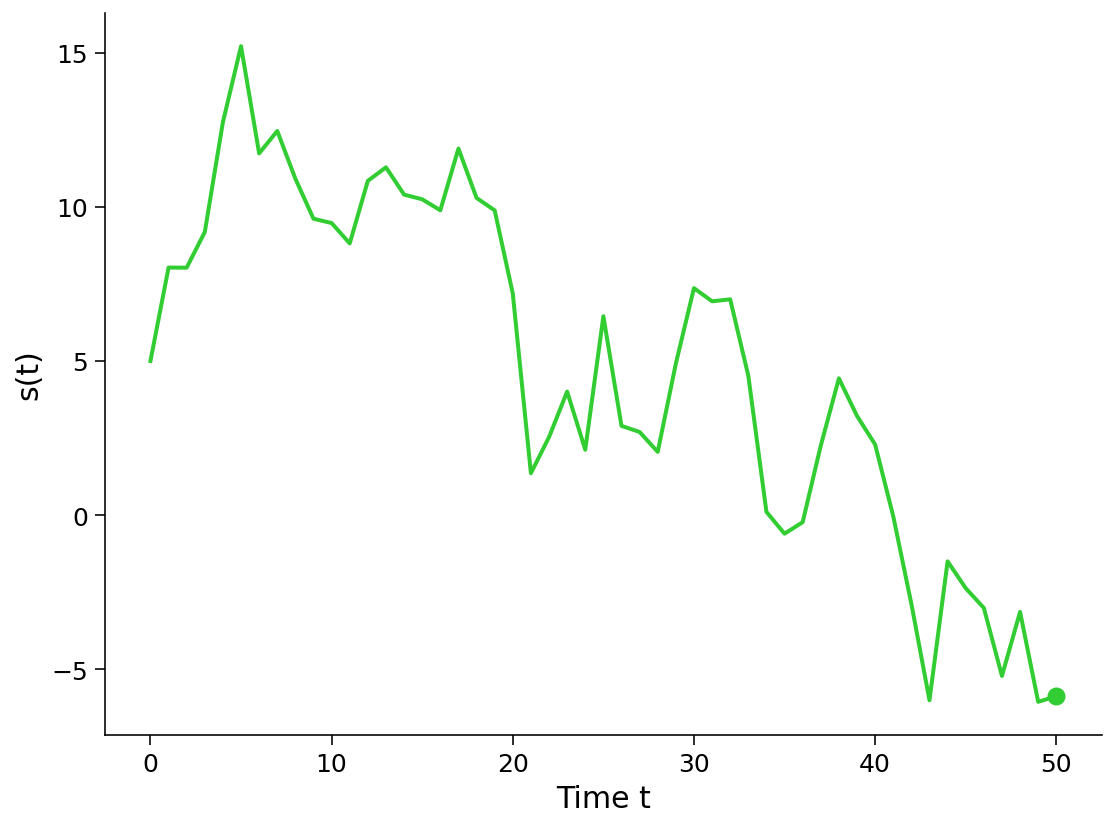

In [8]:
def simulate(D, s0, sigma_p, T):
  """ Compute the response of the linear dynamical system.

  Args:
    D (scalar): dynamics multiplier
    s0 (scalar): initial postion
    sigma_p (scalar): amount of noise in the system (standard deviation)
    T (scalar): total duration of the simulation

  Returns:
    ndarray: `s`: astrocat's trajectory up to time T
  """

  # Initialize variables
  s = np.zeros(T+1)
  s[0] = s0

  # Compute the position at time t given the position at time t-1 for all t
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(1, len(s)):

    ###################################################################
    ## Fill out the following then remove
    ## raise NotImplementedError("Student exercise: need to implement simulation")
    ###################################################################

    # Update position
    s[t] = D*s[t-1] + np.random.normal(0, sigma_p)

  return s


# Set random seed
np.random.seed(0)

# Set parameters
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Visualize
visualize_Astrocat(s, T)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


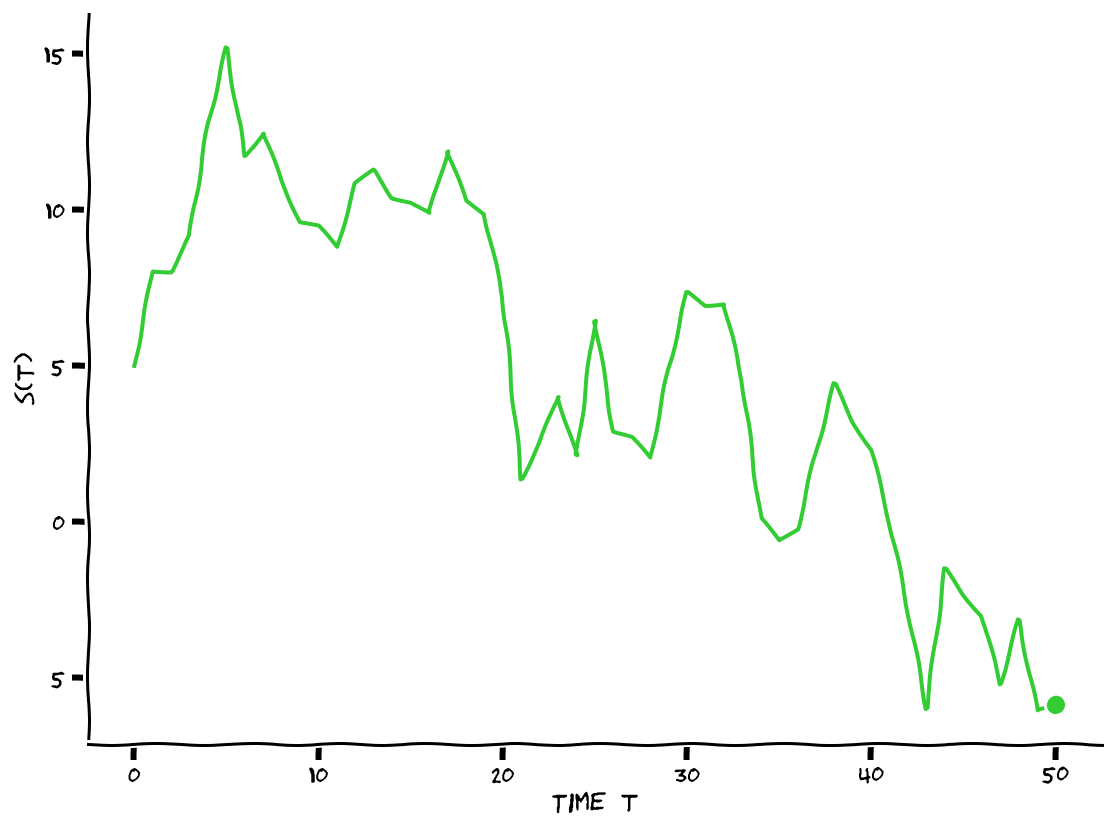

In [9]:
def simulate(D, s0, sigma_p, T):
  """ Compute the response of the linear dynamical system.

  Args:
    D (scalar): dynamics multiplier
    s0 (scalar): initial postion
    sigma_p (scalar): amount of noise in the system (standard deviation)
    T (scalar): total duration of the simulation

  Returns:
    ndarray: `s`: astrocat's trajectory up to time T
  """

  # Initialize variables
  s = np.zeros(T+1)
  s[0] = s0

  # Compute the position at time t given the position at time t-1 for all t
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(1, len(s)):

    # Update position
    s[t] = D*s[t-1] + np.random.normal(0, sigma_p)

  return s


# Set random seed
np.random.seed(0)

# Set parameters
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Visualize
with plt.xkcd():
  visualize_Astrocat(s, T)

### Interactive Demo 1.1: Playing with Astrocat movement

We will use the function you just implemented in a demo, where you can change the value of $D$ and see what happens.


1.   What happens when D is large (>1)? Why?
2.   What happens when D is a large negative number (<-1)? Why?
3.   What about when D is zero?

In [10]:
# @markdown Execute this cell to enable the demo


@widgets.interact(D=widgets.FloatSlider(value=-.5, min=-2, max=2, step=0.1))
def plot(D=D):

    # Set parameters
    T = 50      # total time duration
    s0 = 5.     # initial condition of s at time 0
    sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit

    # Simulate Astrocat
    s = simulate(D, s0, sigma_p, T)

    # Visualize
    visualize_Astrocat(s, T)

interactive(children=(FloatSlider(value=-0.5, description='D', max=2.0, min=-2.0), Output()), _dom_classes=('w…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial3_Solution_00d44150.py)



In [11]:
# @title Video 3: Exercise 1.1 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1RU4y1n7Rh", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="hxnffxb1O3M", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 1.2: Measuring Astrocat's movements

*Estimated timing to here from start of tutorial: 10 min*

### Coding Exercise 1.2.1: Reading measurements from Astrocat's collar



In [12]:
# @title Video 4: Reading measurements from Astrocat's collar
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Xy4y1L7fh", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="2csLl3R3NoU", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

We will estimate Astrocat's actual position using measurements of a noisy sensor attached to its collar. 

Complete the function below to read measurements from Astrocat's collar. These measurements are correct except for additive Gaussian noise whose standard deviation is given by the input argument `sigma_measurements`.

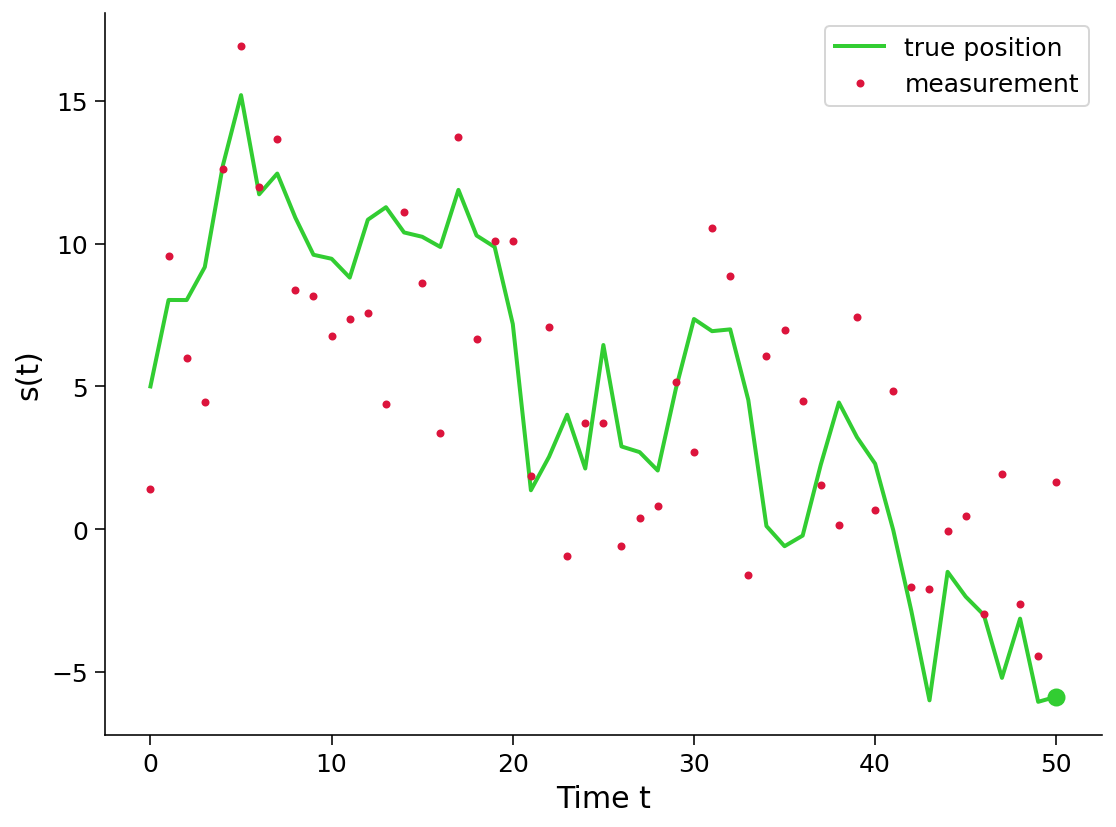

In [13]:
def read_collar(s, sigma_measurements):
  """ Compute the measurements of the noisy sensor attached to astrocat's collar

  Args:
    s (ndarray): astrocat's true position over time
    sigma_measurements (scalar): amount of noise in the sensor (standard deviation)

  Returns:
    ndarray: `m`: astrocat's position over time according to the sensor
  """

  # Initialize variables
  m = np.zeros(len(s))

  # For all time t, add white Gaussian noise with magnitude sigma_measurements
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(len(s)):

    ###################################################################
    ## Fill out the following then remove
    ## raise NotImplementedError("Student exercise: need to implement read_collar function")
    ###################################################################

    # Read measurement
    m[t] = s[t] + np.random.normal(0, sigma_measurements)

  return m


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize
plot_measurement(s, m, T)

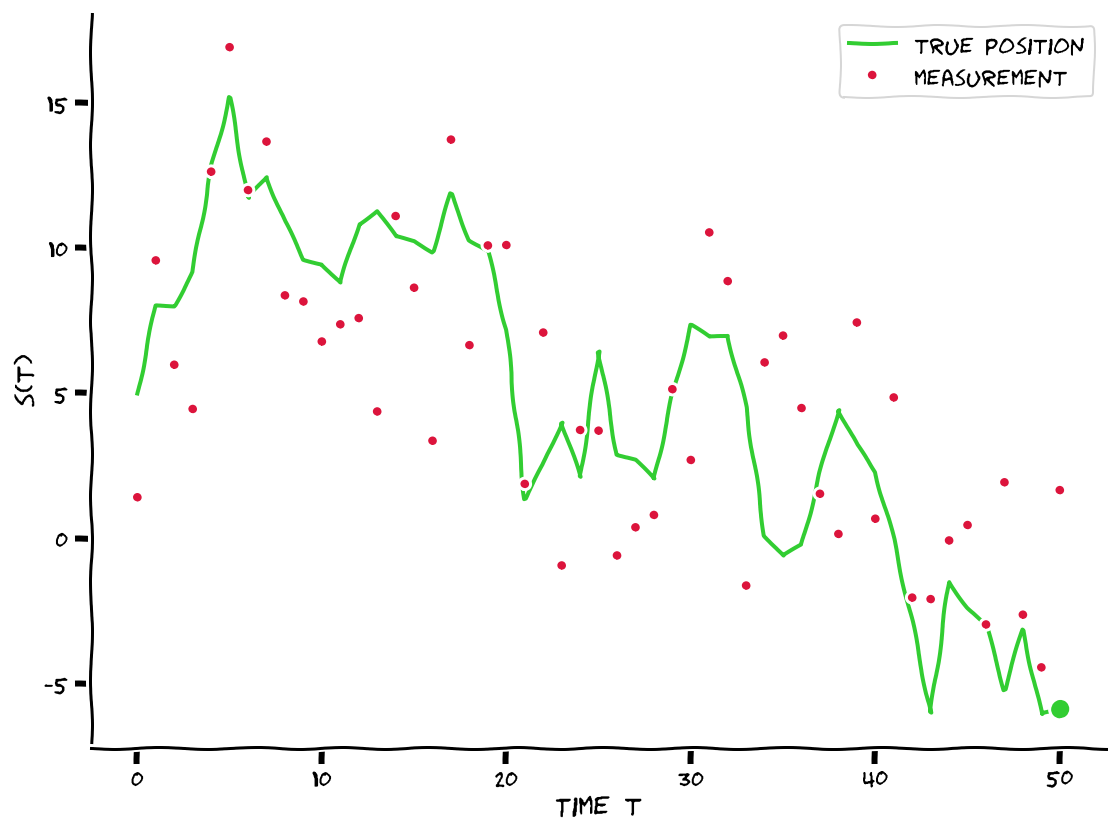

In [14]:
def read_collar(s, sigma_measurements):
  """ Compute the measurements of the noisy sensor attached to astrocat's collar

  Args:
    s (ndarray): astrocat's true position over time
    sigma_measurements (scalar): amount of noise in the sensor (standard deviation)

  Returns:
    ndarray: `m`: astrocat's position over time according to the sensor
  """

  # Initialize variables
  m = np.zeros(len(s))

  # For all time t, add white Gaussian noise with magnitude sigma_measurements
  # Consider that np.random.normal(mu, sigma) generates a random sample from
  # a gaussian with mean = mu and standard deviation = sigma

  for t in range(len(s)):

    # Read measurement
    m[t] = s[t] + np.random.normal(0, sigma_measurements)

  return m


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize
with plt.xkcd():
  plot_measurement(s, m, T)

In [15]:
# @title Video 5: Exercise 1.2.1 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1y44y1274K", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="O0Sxu5mtsqY", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Coding Exercise 1.2.2: Compare true states to measured states



In [16]:
# @title Video 6: Comparing true states to measured states
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Jf4y157sv", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="BulWhzSPhmQ", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Make a scatter plot to see how bad the measurements of Astrocat's collar are. This exercise will show why using only the measures to track Astrocat can be catastrophic.

A Kalman filter will solve this problem!

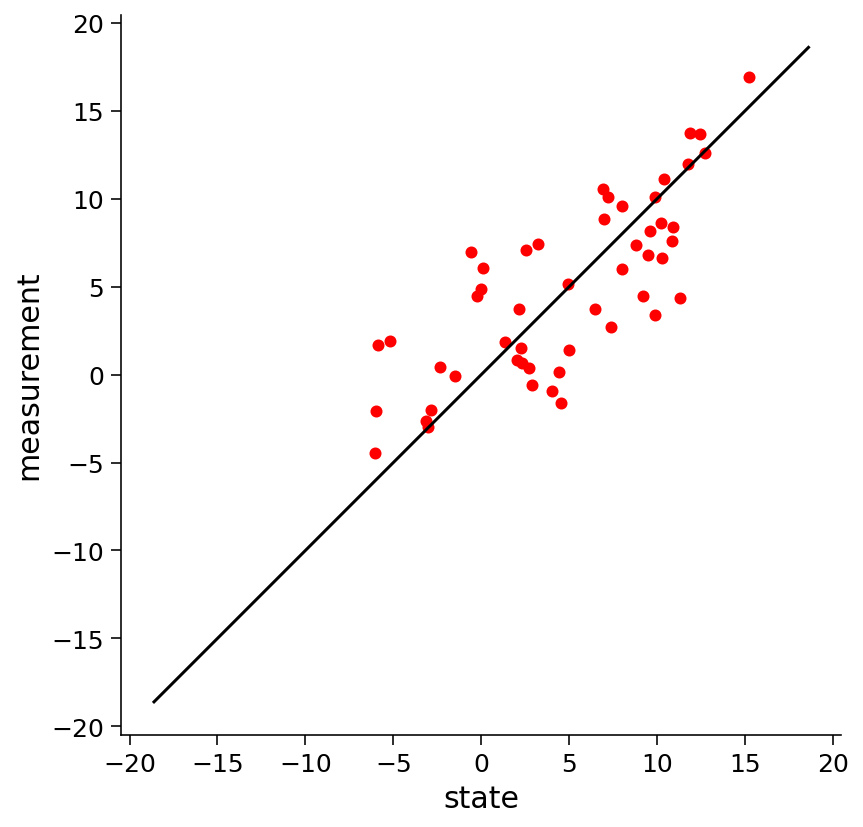

In [17]:
def compare(s, m):
  """ Compute a scatter plot

  Args:
    s (ndarray): astrocat's true position over time
    m (ndarray): astrocat's measured position over time according to the sensor

  """


  ###################################################################
  ## Fill out the following then remove
  ## raise NotImplementedError("Student exercise: need to implement compare function")
  ###################################################################

  fig = plt.figure()
  ax = fig.add_subplot(111)
  sbounds = 1.1*max(max(np.abs(s)), max(np.abs(m)))
  ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
  ax.set_xlabel('state')
  ax.set_ylabel('measurement')
  ax.set_aspect('equal')

  # Complete a scatter plot: true state versus measurements
  plt.scatter(s, m, marker='.', color='red', s=100)


# Set parameters
np.random.seed(0)
D = 0.9    # parameter in s(t)
T = 50      # total time duration
s0 = 5.     # initial condition of s at time 0
sigma_p = 2 # amount of noise in the actuators of astrocat's propulsion unit
sigma_measurements = 4 # amount of noise in astrocat's collar

# Simulate Astrocat
s = simulate(D, s0, sigma_p, T)

# Take measurement from collar
m = read_collar(s, sigma_measurements)

# Visualize true vs measured states
compare(s,m)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial3_Solution_c71fc85e.py)

*Example output:*

<img alt='Solution hint' align='left' width=848.0 height=827.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_c71fc85e_0.png>



In [18]:
# @title Video 7: Exercise 1.2.2 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Mg411M7m6", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="pOa8PdXa60s", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
# Section 2: The Kalman filter



## Section 2.1: Using the Kalman filter

*Estimated timing to here from start of tutorial: 20 min*

In [19]:
# @title Video 8: The Kalman filter
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1bP4y147ud", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="4fjCv9FKHYI", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Interactive Demo 2.1: The Kalman filter in action

Next we provide you with an interactive visualization to understand how the Kalman filter works. Play with the sliders to gain an intuition for how the different factors affect the Kalman filter's inferences. You will code the Kalman filter yourself in the next exercise.

The sliders:
* current time: Kalman filter synthesizes measurements up until this time.
* dynamics time constant $\tau$: this determines the dynamics value, $D=\exp^{-\Delta t/\tau}$ where $\Delta t$ is the discrete time step (here 1).
* process noise: amount of noise in the actuators of astrocat's propulsion unit
* observation noise: the noise levels of our measurements (when we read the collar)

Some questions to consider:
- What affects the predictability of Astrocat?
- How does confidence change over time?
- What affects the relative weight of the new measurement?
- How is the error related to the posterior variance?

In [20]:
# @markdown Execute this cell to enable the demo. It takes a few seconds to update so please be patient.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(T_max/4, description="current time", min=1, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2, description='dynamics time constant', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_s = widgets.Checkbox(value=True, description='state', disabled=True, indent=False),
                  flag_m = widgets.Checkbox(value=False, description='measurement', disabled=False, indent=False),
                  flag_s_ = widgets.Checkbox(value=False, description='estimate', disabled=False, indent=False),
                  flag_err_ = widgets.Checkbox(value=False, description='estimator confidence intervals', disabled=False, indent=False))

def stochastic_system(T, tau, process_noise, measurement_noise, flag_m, flag_s_, flag_err_):
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)
    process_noise_cov = process_noise**2
    measurement_noise_cov = measurement_noise**2

    prior_mean = 0
    prior_cov = process_noise_cov/(1-D**2)

    s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    captured_prior = None
    captured_likelihood = None
    captured_posterior = None

    onfilter = True
    for i in range(1, T_max):
        s[i] = D * s[i-1] + process_noise * unit_process_noise[i-1]

        if onfilter:
          m[i] = s[i] + measurement_noise * unit_measurement_noise[i]

          prior, likelihood, posterior = filter(D, process_noise_cov, measurement_noise_cov, posterior, m[i])

          s_[i] =  posterior.mean
          cov_[i] = posterior.cov

        if i == T:
          onfilter = False
          captured_prior = prior
          captured_likelihood = likelihood
          captured_posterior = posterior

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T_max+(T_max*pscale)])
    ax.set_ylim([smin, smax])

    show_pdf = [False, False]
    ax.plot(t[:T+1], s[:T+1], color='limegreen', lw=2)
    ax.plot(t[T:], s[T:], color='limegreen', lw=2, alpha=0.3)
    ax.plot([t[T:T+1]], [s[T:T+1]], marker='o', markersize=8, color='limegreen')

    if flag_m:
        ax.plot(t[:T+1], m[:T+1], '.', color='crimson', lw=2)
        ax.plot([t[T:T+1]], [m[T:T+1]], marker='o', markersize=8, color='crimson')

        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_likelihood = norm.pdf(domain, captured_likelihood.mean, np.sqrt(captured_likelihood.cov))
        ax.fill_betweenx(domain, T + pdf_likelihood*(T_max*pscale), T, color='crimson', alpha=0.5, label='likelihood', edgecolor="crimson", linewidth=0)
        ax.plot(T + pdf_likelihood*(T_max*pscale), domain, color='crimson', linewidth=2.0)

        ax.legend(ncol=3, loc='upper left')
        show_pdf[0] = True

    if flag_s_:
        ax.plot(t[:T+1], s_[:T+1], color='black', lw=2)
        ax.plot([t[T:T+1]], [s_[T:T+1]], marker='o', markersize=8, color='black')
        show_pdf[1] = True

    if flag_err_:
        ax.fill_between(t[:T+1], s_[:T+1] + 2 * np.sqrt(cov_)[:T+1], s_[:T+1] - 2 * np.sqrt(cov_)[:T+1], color='black', alpha=0.3)
        show_pdf[1] = True

    if show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_post = norm.pdf(domain, captured_posterior.mean, np.sqrt(captured_posterior.cov))
        ax.fill_betweenx(domain, T + pdf_post*(T_max*pscale), T, color='black', alpha=0.5, label='posterior', edgecolor="black", linewidth=0)
        ax.plot(T + pdf_post*(T_max*pscale), domain, color='black', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

    if show_pdf[0] and show_pdf[1]:
        domain = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500)
        pdf_prior = norm.pdf(domain, captured_prior.mean, np.sqrt(captured_prior.cov))
        ax.fill_betweenx(domain, T + pdf_prior*(T_max*pscale), T, color='dodgerblue', alpha=0.5, label='prior', edgecolor="dodgerblue", linewidth=0)
        ax.plot(T + pdf_prior*(T_max*pscale), domain, color='dodgerblue', linewidth=2.0)
        ax.legend(ncol=3, loc='upper left')

plt.show()

interactive(children=(IntSlider(value=50, description='current time', max=199, min=1), FloatSlider(value=25.0,…

In [21]:
# @title Video 9: Interactive Demo 2.1 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1ko4y1D78w", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="Vif-dLc5ilE", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

### Coding Exercise 2.1: Implement your own Kalman filter



In [22]:
# @title Video 10: Implementing a Kalman filter
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Gy4y1j7YY", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="aTy1ScpTGHU", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

As you saw in the video and the previous exercise, a Kalman filter estimates a posterior probability distribution *recursively* over time using a mathematical model of the process and incoming measurements. This dynamic posterior allows us to improve our guess about Astrocat's position as new measures arrive; besides, its mean is the best estimate one can compute of Astrocat's actual position at each time step.

Now it's your turn! Follow this recipe to complete the code below and implement your own Kalman filter:

**Step 1: Change yesterday's posterior into today's prior** 

Use the mathematical model to calculate how deterministic changes in the process shift yesterday's posterior, $\mathcal{N}(\mu_{s_{t-1}}, \sigma_{s_{t-1}}^2)$, and how random changes in the process broaden the shifted distribution:

> $p(s_t|m_{1:t-1}) = p(Ds_{t-1}+w_{t-1} | m_{1:t-1}) = \mathcal{N}(D\mu_{s_{t-1}} + 0, D^2\sigma_{s_{t-1}}^2 +\sigma_p^2)$

Note that we use $\sigma_p$ here to denote the process noise, while the video used $\sigma_w$ (a change in notation to sync with the prior sections).

**Step 2: Multiply today's prior by likelihood** 

Use the latest measurement of Astrocat's collar (fresh evidence) to form a new estimate somewhere between this measurement and what we predicted in Step 1. The next posterior is the result of multiplying the Gaussian computed in Step 1 (a.k.a. today's prior) and the likelihood, which is also modeled as a Gaussian $\mathcal{N}(m_t, \sigma_m^2)$:

**2a: add information from prior and likelihood** 

To find the posterior variance, we first compute the posterior information (which is the inverse of the variance) by adding the information provided by the prior and the likelihood:

> $\frac{1}{\sigma_{s_t}^2} = \frac{1}{D^2\sigma_{s_{t-1}}^2 +\sigma_p^2} + \frac{1}{\sigma_m^2} $

Now we can take the inverse of the posterior information to get back the posterior variance.

**2b: add means from prior and likelihood** 

To find the posterior mean, we calculate a weighted average of means from prior and likelihood, where each weight, $g$, is just the fraction of information that each Gaussian provides!

> $g_{\rm{prior}} = \frac{\rm{information}_{\textit{ }\rm{prior}}}{\rm{information}_{\textit{ }\rm{posterior}}}$
>
> $g_{\rm{likelihood}} = \frac{\rm{information}_{\textit{ }\rm{likelihood}}}{\rm{information}_{\textit{ }\rm{posterior}}}$
>
> $\bar{\mu}_t = g_{\rm{prior}} D\mu_{s_{t-1}} + g_{\rm{likelihood}} m_t$ 
    
Congrats!

**Implementation detail:** You can access the statisics of a Gaussian by typing, e.g., 

```
prior.mean
prior.cov
```

**Optional: Relationship to classic description of Kalman filter:**

We're teaching this recipe because it is interpretable and connects to past lessons about the sum rule and product rule for Gaussians. But the classic description of the Kalman filter is a little different. The above weights, $g_{\rm{prior}}$ and $g_{\rm{likelihood}}$, add up to $1$ and can be written one in terms of the other; then, if we let $K = g_{\rm{likelihood}}$, the posterior mean can be expressed as:

$\bar{\mu}_t = (1-K) D\bar{\mu}_{t-1} + K m_t = D\bar{\mu}_{t-1} + K (m_t - D\bar{\mu}_{t-1})$ 

In classic textbooks, you will often find this expression for the posterior mean; $K$ is known as the Kalman gain and its function is to choose a value partway between the current measurement $m_t$ and the prediction from Step 1.

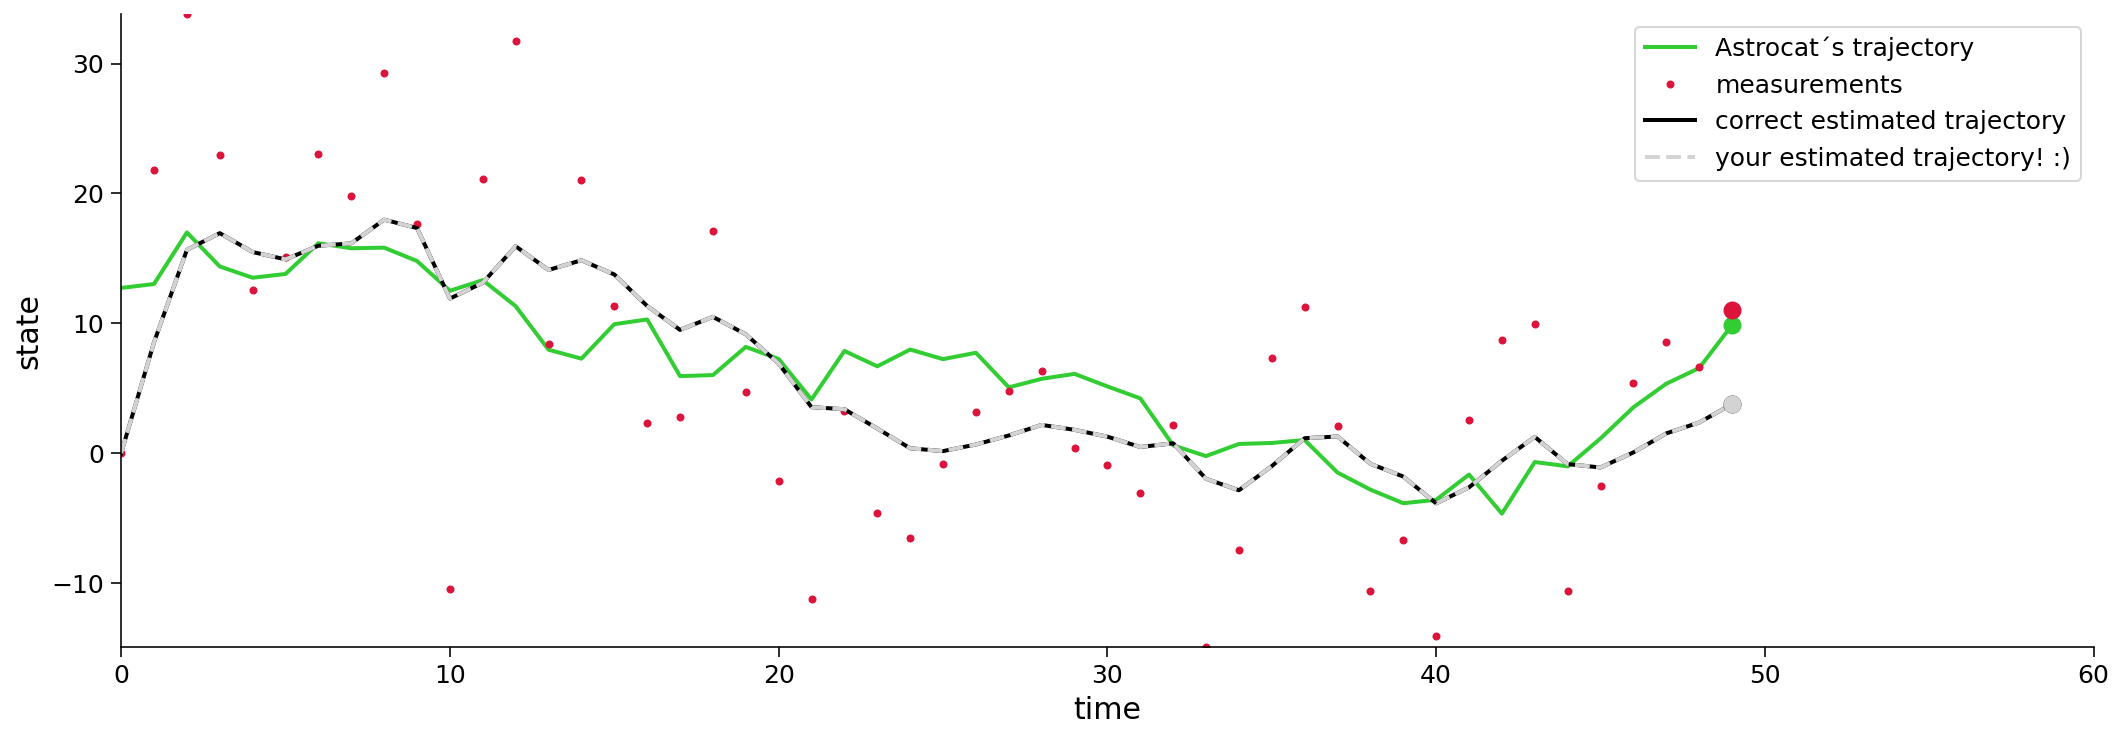

In [24]:
# Set random seed
np.random.seed(0)

# Set parameters
T = 50                  # Time duration
tau = 25                # dynamics time constant
process_noise = 2       # process noise in Astrocat's propulsion unit (standard deviation)
measurement_noise = 9   # measurement noise in Astrocat's collar (standard deviation)

# Auxiliary variables
process_noise_cov = process_noise**2          # process noise in Astrocat's propulsion unit (variance)
measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

# Initialize arrays
t = np.arange(0, T, 1)   # timeline
s = np.zeros(T)          # states
D = np.exp(-1/tau)       # dynamics multiplier (matrix if s is vector)

m = np.zeros(T)          # measurement
s_ = np.zeros(T)         # estimate (posterior mean)
cov_ = np.zeros(T)       # uncertainty (posterior covariance)

# Initial guess of the posterior at time 0
initial_guess = gaussian(0, process_noise_cov/(1-D**2))    # In this case, the initial guess (posterior distribution
                                                           # at time 0) is the equilibrium distribution, but feel free to
                                                           # experiment with other gaussians
posterior = initial_guess

# Sample initial conditions
s[0] = posterior.mean + np.sqrt(posterior.cov) * np.random.randn()   # Sample initial condition from posterior distribution at time 0
s_[0] = posterior.mean
cov_[0] = posterior.cov

# Loop over steps
for i in range(1, T):

    # Sample true states and corresponding measurements
    s[i] = D * s[i-1] + np.random.normal(0, process_noise)    # variable `s` records the true position of Astrocat
    m[i] = s[i] + np.random.normal(0, measurement_noise)      # variable `m` records the measurements of Astrocat's collar

    ###################################################################
    ## Fill out the following then remove
    ## raise NotImplementedError("Student exercise: need to implement the Kalman filter")
    ###################################################################

    # Step 1. Shift yesterday's posterior to match the deterministic change of the system's dynamics,
    #         and broad it to account for the random change (i.e., add mean and variance of process noise).
    todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise_cov)

    # Step 2. Now that yesterday's posterior has become today's prior, integrate new evidence
    #         (i.e., multiply gaussians from today's prior and likelihood)
    likelihood = gaussian(m[i], measurement_noise_cov)

    # Step 2a:  To find the posterior variance, add informations (inverse variances) of prior and likelihood
    info_prior = 1/todays_prior.cov
    info_likelihood = 1/likelihood.cov
    info_posterior = info_prior + info_likelihood

    # Step 2b: To find the posterior mean, calculate a weighted average of means from prior and likelihood;
    #          the weights are just the fraction of information that each gaussian provides!
    prior_weight = info_prior / info_posterior
    likelihood_weight = info_likelihood / info_posterior
    posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean


    # Don't forget to convert back posterior information to posterior variance!
    posterior_cov = 1/info_posterior
    posterior = gaussian(posterior_mean, posterior_cov)

    s_[i] = posterior.mean
    cov_[i] = posterior.cov

# Visualize
paintMyFilter(D, initial_guess, process_noise_cov, measurement_noise_cov, s, m, s_, cov_)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_HiddenDynamics/solutions/W3D2_Tutorial3_Solution_bedeaebf.py)

*Example output:*

<img alt='Solution hint' align='left' width=2128.0 height=746.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_HiddenDynamics/static/W3D2_Tutorial3_Solution_bedeaebf_0.png>



In [25]:
# @title Video 11: Exercise 2.1 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1xg411M7Gy", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="mmiwlenUiMo", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.2: Estimation accuracy

*Estimated timing to here from start of tutorial: 50 min*

### Interactive Demo 2.2: Compare states, estimates, and measurements



In [26]:
# @title Video 12: Compare states, estimates, and measurements
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Fy4y1j75Z", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="AZUObJuc5Bw", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

How well do the estimates $\hat{s}$ match the actual values $s$? How does the distribution of errors $\hat{s}_t - s_t$ compare to the posterior variance? Why? Try different parameters of the Hidden Markov Model and observe how the properties change.

How do the _measurements_ $m$ compare to the true states?

In [27]:
# @markdown Execute cell to enable the demo
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(tau=widgets.FloatSlider(tau_max/2, description='tau', min=tau_min, max=tau_max),
                  process_noise=widgets.FloatSlider(2, description="process noise", min=process_noise_min, max=process_noise_max),
                  measurement_noise=widgets.FloatSlider(3, description="observation noise", min=measurement_noise_min, max=measurement_noise_max),
                  flag_m = widgets.Checkbox(value=False, description='measurements', disabled=False, indent=False))

def stochastic_system(tau, process_noise, measurement_noise, flag_m):
    T = T_max
    t = np.arange(0, T_max, 1)              # timeline
    s = np.zeros(T_max)                     # states
    D = np.exp(-1/tau)                      # dynamics multiplier (matrix if s is vector)

    process_noise_cov = process_noise**2          # process noise in Astrocat's propulsion unit (variance)
    measurement_noise_cov = measurement_noise**2  # measurement noise in Astrocat's collar (variance)

    prior_mean = 0
    prior_cov = process_noise_cov/(1-D**2)


    s[0] = np.sqrt(prior_cov) * np.random.randn()   # Sample initial condition from equilibrium distribution

    m = np.zeros(T_max)    # measurement
    s_ = np.zeros(T_max)    # estimate (posterior mean)
    cov_ = np.zeros(T_max)    # uncertainty (posterior covariance)

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    for i in range(1, T):
        s[i] = D * s[i-1] + process_noise * np.random.randn()
        m[i] = s[i] + measurement_noise * np.random.randn()

        prior, likelihood, posterior = filter(D, process_noise_cov, measurement_noise_cov, posterior, m[i])

        s_[i] =  posterior.mean
        cov_[i] = posterior.cov

    fig = plt.figure(figsize=[10, 5])
    ax = plt.subplot(1, 2, 1)
    ax.set_xlabel('s')
    ax.set_ylabel('$\mu$')

    sbounds = 1.1*max(max(np.abs(s)), max(np.abs(s_)), max(np.abs(m)))
    ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
    ax.errorbar(s, s_, yerr=2*np.sqrt(cov_[-1]), marker='.', mfc='black', mec='black', linestyle='none', color='gray')

    axhist = plt.subplot(1, 2, 2)
    axhist.set_xlabel('error $s-\hat{s}$')
    axhist.set_ylabel('probability')
    axhist.hist(s-s_, density=True, bins=25, alpha=.5, label='histogram of estimate errors', color='yellow')

    if flag_m:
        ax.plot(s, m, marker='.', linestyle='none', color='red')
        axhist.hist(s-m,density=True,bins=25,alpha=.5,label='histogram of measurement errors',color='orange')

    domain = np.arange(-sbounds, sbounds, 0.1)
    pdf_g = norm.pdf(domain, 0, np.sqrt(cov_[-1]))
    axhist.fill_between(domain, pdf_g, color='black', alpha=0.5, label=r'posterior shifted to mean')
    axhist.legend()

plt.show()

interactive(children=(FloatSlider(value=25.0, description='tau', max=50.0, min=1.0), FloatSlider(value=2.0, de…

In [28]:
# @title Video 13: Interactive Demo 2.2 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1EU4y1n7ew", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="nK46HBTy4Y8", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.3: Searching for Astrocat

*Estimated timing to here from start of tutorial: 1 hour*

### Interactive Demo 2.3: How long does it take to find astrocat?



In [29]:
# @title Video 14: How long does it take to find astrocat?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1AX4y1c72s", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="4prm8bZr4no", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


Here we plot the posterior variance as a function of time. Before mission control gets measurements, their only information about astrocat's location is the prior. After some measurements, they hone in on astrocat.
* How does the variance shrink with time?
* The speed depends on the process dynamics, but does it also depend on the signal-to-noise ratio (SNR)? (Here we measure SNR in decibels, a log scale where 1 dB means 0.1 log unit.)

The red curve shows how rapidly the latent variance equilibrates exponentially from an initial condition, with a time constant of $\sim 1/(1-D^2)$. (**Note:** We adjusted the curve by shifting and scaling so it lines up visually with the posterior equilibrium variance. This makes it easier to compare timescales.) Does the latent process converge faster or slower than the posterior? Can you explain this based on how the Kalman filter integrates evidence?

In [30]:
# @markdown Execute this cell to enable the demo

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(T=widgets.IntSlider(tau_max, description="max time", min=2, max=T_max-1),
                  tau=widgets.FloatSlider(tau_max/2, description='time constant', min=tau_min, max=tau_max),
                  SNRdB=widgets.FloatSlider(-20., description="SNR (decibels)", min=-40., max=10.))

def stochastic_system(T, tau, SNRdB):

    t = np.arange(0, T, 1)              # timeline
    s = np.zeros(T)                     # states
    D = np.exp(-1/tau)                  # dynamics matrix (scalar here)
    prior_mean = 0
    process_noise = 1
    SNR = 10**(.1*SNRdB)
    measurement_noise = process_noise / SNR
    prior_cov = process_noise/(1-D**2)

    s[0] = np.sqrt(prior_cov) * unit_process_noise[0]   # Sample initial condition from equilibrium distribution

    m = np.zeros(T)    # measurements
    s_ = np.zeros(T)    # estimates (posterior mean)
    cov_ = np.zeros(T)    # uncertainty (posterior covariance)
    pcov = np.zeros(T)    # process covariance

    s_[0] = prior_mean
    cov_[0] = prior_cov
    posterior = gaussian(prior_mean, prior_cov)

    for i in range(1, T):
        s[i] = D * s[i-1] + np.sqrt(process_noise) * unit_process_noise[i-1]
        m[i] = s[i] + np.sqrt(measurement_noise) * unit_measurement_noise[i]

        prior, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i])

        s_[i] =  posterior.mean
        cov_[i] = posterior.cov
        pcov[i] = D**2 * pcov[i-1] + process_noise

    equilibrium_posterior_var = process_noise * (D**2 - 1 - SNR + np.sqrt((D**2 - 1 - SNR)**2 + 4 * D**2 * SNR)) / (2 * D**2 * SNR)

    equilibrium_process_var = process_noise / (1-D**2)

    scale = (max(cov_) - equilibrium_posterior_var) / equilibrium_process_var
    pcov = pcov * scale   # scale for better visual comparison of temporal structure

    fig, ax = plt.subplots()
    ax.set_xlabel('time')
    ax.set_xlim([0, T])

    ax.fill_between(t, 0, cov_, color='black', alpha=0.3)
    ax.plot(t, cov_, color='black', label='posterior variance')
    ax.set_ylabel('posterior variance')
    ax.set_ylim([0, max(cov_)])

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.fill_between(t, min(pcov), pcov, color='red', alpha=0.3)
    ax2.plot(t, pcov, color='red', label='hidden process variance')
    ax2.set_ylabel('hidden process variance (scaled)', color='red', rotation=-90, labelpad=20)

    ax2.tick_params(axis='y', labelcolor='red')
    # ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax2.set_yticks([0, equilibrium_process_var - equilibrium_posterior_var])
    ax2.set_yticklabels(['0', 'equilibrium\nprocess var'])
    ax2.set_ylim([max(cov_), 0])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

interactive(children=(IntSlider(value=50, description='max time', max=199, min=2), FloatSlider(value=25.0, des…

In [31]:
# @title Video 15: Interactive Demo 2.3 Discussion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1ng411M7N5", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="AYOkyKnfPNM", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


**Applications of Kalman filter in brain science**

* Brain-Computer Interface: estimate intended movements using neural activity as measurements.
* Data analysis: estimate brain activity from noisy measurements (e.g. EEG)
* Model of perception: prey tracking using noisy sensory measurements
* Imagine your own! When are you trying to estimate something you cannot see directly?

There are many variants that improve upon the limitations of the Kalman filter: non-Gaussian states and measurements, nonlinear dynamics, and more.

---
# Summary

*Estimated timing of tutorial: 1 hour, 15 minutes*

In this tutorial, you:
- simulated a 1D continuous linear dynamical system and took noisy measurements of the hidden state
- used a Kalman filter to recover the hidden states more accurately than if you just used the noisy measurements and connected this to Bayesian ideas
- played around with parameters of the process to better understand Kalman filter behavior
